In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training")
else:
    print("GPU not detected, using CPU")

# Constants
TRAIN_DIR = 'imageCategoryData/train_data'
VAL_DIR = 'imageCategoryData/val_data'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 8
EPOCHS = 50
NUM_CLASSES = 12  # Adjust based on the number of categories in your dataset

# Directory Setup
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Data Augmentation
def get_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    return train_generator, val_generator


# Model Architecture 
def build_model(architecture='vgg16'):
    if architecture == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif architecture == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif architecture == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif architecture == 'resnet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else:
        raise ValueError("Unsupported architecture")

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Save Model with Accuracy in Filename
def save_model_with_accuracy(model, history, architecture):
    final_accuracy = history.history['val_accuracy'][-1]
    accuracy_percent = int(final_accuracy * 100)
    model_name = f"{architecture}_valacc{accuracy_percent}.keras"
    model_path = os.path.join('models', model_name)
    model.save(model_path)
    print(f"Model saved: {model_path}")


# Training the Model
def train_model(architecture='vgg16'):
    train_generator, val_generator = get_data_generators()

    model = build_model(architecture)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE
    )

    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

    # Save model with accuracy in name
    save_model_with_accuracy(model, history, architecture)

    return model, history


# Evaluate the Model
def evaluate_model(model, val_generator, architecture):
    val_labels = val_generator.classes
    val_predictions = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE + 1, verbose=1)
    val_predictions = np.argmax(val_predictions, axis=1)

    report = classification_report(val_labels, val_predictions, target_names=val_generator.class_indices.keys())
    print("Classification Report:\n", report)

    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Save Confusion Matrix plot
    plt.savefig(f'plots/{architecture}_confusion_matrix.png')
    plt.close()


# Plot training and validation accuracy and loss
def plot_metrics(history, architecture):
    plt.figure(figsize=(12, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Plot')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save training metrics plot
    plt.savefig(f'plots/{architecture}_metrics.png')
    plt.close()


# Convert to TensorFlow Lite
def convert_to_tflite(model, architecture):
    model_path = f"models/{architecture}_saved_model"
    tflite_model_path = f"models/{architecture}_model.tflite"

    model.save(model_path)
    print(f"Model saved to {model_path}")

    # Convert model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()

    # Save TFLite model
    with open(tflite_model_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model saved to {tflite_model_path}")





Using GPU for training


In [2]:
# Automated training, saving, evaluation, and conversion for multiple architectures
architectures = ['vgg16', 'vgg19', 'resnet50', 'resnet101']

for architecture in architectures:
    print(f"Training model: {architecture}")
    
    # Train model for the given architecture
    model, history = train_model(architecture)
    
    # Save training metrics plots
    plot_metrics(history, architecture)

    # Evaluate the model
    print(f"Evaluating model: {architecture}")
    train_generator, val_generator = get_data_generators()
    evaluate_model(model, val_generator, architecture)

    # Convert model to TensorFlow Lite
    convert_to_tflite(model, architecture)

Training model: vgg16
Found 300 images belonging to 12 classes.
Found 196 images belonging to 12 classes.
Epoch 1/50
37/37 [==============================] - 29s 338ms/step - loss: 2.5069 - accuracy: 0.1336 - val_loss: 1.9981 - val_accuracy: 0.4323
Epoch 2/50
37/37 [==============================] - 10s 272ms/step - loss: 2.0619 - accuracy: 0.3185 - val_loss: 1.7528 - val_accuracy: 0.5469
Epoch 3/50
37/37 [==============================] - 10s 259ms/step - loss: 1.8035 - accuracy: 0.4418 - val_loss: 1.4583 - val_accuracy: 0.5260
Epoch 4/50
37/37 [==============================] - 9s 254ms/step - loss: 1.5985 - accuracy: 0.5308 - val_loss: 1.3683 - val_accuracy: 0.5573
Epoch 5/50
37/37 [==============================] - 9s 253ms/step - loss: 1.4113 - accuracy: 0.5582 - val_loss: 1.2776 - val_accuracy: 0.6094
Epoch 6/50
37/37 [==============================] - 9s 250ms/step - loss: 1.3201 - accuracy: 0.6027 - val_loss: 1.1000 - val_accuracy: 0.6927
Epoch 7/50
37/37 [=====================

d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

INFO:tensorflow:Assets written to: models/vgg16_saved_model\assets


INFO:tensorflow:Assets written to: models/vgg16_saved_model\assets


Model saved to models/vgg16_saved_model
TFLite model saved to models/vgg16_model.tflite
Training model: vgg19
Found 300 images belonging to 12 classes.
Found 196 images belonging to 12 classes.
80134624/80134624 [==============================] - 163s 2us/step
Epoch 1/50
37/37 [==============================] - 8s 188ms/step - loss: 2.5633 - accuracy: 0.1301 - val_loss: 2.1606 - val_accuracy: 0.3594
Epoch 2/50
37/37 [==============================] - 7s 182ms/step - loss: 2.2477 - accuracy: 0.2363 - val_loss: 1.9829 - val_accuracy: 0.3750
Epoch 3/50
37/37 [==============================] - 7s 182ms/step - loss: 1.9753 - accuracy: 0.4247 - val_loss: 1.6768 - val_accuracy: 0.5104
Epoch 4/50
37/37 [==============================] - 7s 183ms/step - loss: 1.8066 - accuracy: 0.4178 - val_loss: 1.5848 - val_accuracy: 0.5625
Epoch 5/50
37/37 [==============================] - 7s 183ms/step - loss: 1.6641 - accuracy: 0.5068 - val_loss: 1.4379 - val_accuracy: 0.5990
Epoch 6/50
37/37 [===========

d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

INFO:tensorflow:Assets written to: models/vgg19_saved_model\assets


INFO:tensorflow:Assets written to: models/vgg19_saved_model\assets


Model saved to models/vgg19_saved_model
TFLite model saved to models/vgg19_model.tflite
Training model: resnet50
Found 300 images belonging to 12 classes.
Found 196 images belonging to 12 classes.
Epoch 1/50
37/37 [==============================] - 10s 174ms/step - loss: 2.8843 - accuracy: 0.1027 - val_loss: 2.5940 - val_accuracy: 0.0573
Epoch 2/50
37/37 [==============================] - 4s 117ms/step - loss: 2.6009 - accuracy: 0.0993 - val_loss: 2.4733 - val_accuracy: 0.0677
Epoch 3/50
37/37 [==============================] - 5s 121ms/step - loss: 2.5362 - accuracy: 0.0890 - val_loss: 2.4687 - val_accuracy: 0.1406
Epoch 4/50
37/37 [==============================] - 5s 122ms/step - loss: 2.4606 - accuracy: 0.1199 - val_loss: 2.4533 - val_accuracy: 0.1771
Epoch 5/50
37/37 [==============================] - 4s 114ms/step - loss: 2.4630 - accuracy: 0.1336 - val_loss: 2.4729 - val_accuracy: 0.1146
Epoch 6/50
37/37 [==============================] - 4s 111ms/step - loss: 2.4677 - accuracy:

d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

INFO:tensorflow:Assets written to: models/resnet50_saved_model\assets


INFO:tensorflow:Assets written to: models/resnet50_saved_model\assets


Model saved to models/resnet50_saved_model
TFLite model saved to models/resnet50_model.tflite
Training model: resnet101
Found 300 images belonging to 12 classes.
Found 196 images belonging to 12 classes.
171446536/171446536 [==============================] - 356s 2us/step
Epoch 1/50
37/37 [==============================] - 12s 198ms/step - loss: 2.8751 - accuracy: 0.0822 - val_loss: 2.6167 - val_accuracy: 0.0365
Epoch 2/50
37/37 [==============================] - 5s 148ms/step - loss: 2.5648 - accuracy: 0.1149 - val_loss: 2.4835 - val_accuracy: 0.1302
Epoch 3/50
37/37 [==============================] - 5s 146ms/step - loss: 2.5050 - accuracy: 0.1267 - val_loss: 2.4528 - val_accuracy: 0.1615
Epoch 4/50
37/37 [==============================] - 5s 146ms/step - loss: 2.4847 - accuracy: 0.1507 - val_loss: 2.4694 - val_accuracy: 0.1042
Epoch 5/50
37/37 [==============================] - 5s 147ms/step - loss: 2.4397 - accuracy: 0.1301 - val_loss: 2.4614 - val_accuracy: 0.1146
Epoch 6/50
37/37

d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SIH_Neuratech\gpu_ML\MachineLearning\myCuda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

INFO:tensorflow:Assets written to: models/resnet101_saved_model\assets


INFO:tensorflow:Assets written to: models/resnet101_saved_model\assets


Model saved to models/resnet101_saved_model
TFLite model saved to models/resnet101_model.tflite


In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training")
else:
    print("GPU not detected, using CPU")

# Constants
TRAIN_DIR = 'imageCategoryData/train_data'
VAL_DIR = 'imageCategoryData/val_data'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 8
EPOCHS = 50
NUM_CLASSES = 15  # Adjust based on the number of categories in your dataset

# Directory Setup
os.makedirs('models_15cat', exist_ok=True)
os.makedirs('plots_15cat', exist_ok=True)

# Data Augmentation
def get_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    return train_generator, val_generator


# Model Architecture 
def build_model(architecture='vgg16'):
    if architecture == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif architecture == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif architecture == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif architecture == 'resnet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else:
        raise ValueError("Unsupported architecture")

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Model Checkpoint Callback
def get_model_checkpoint(architecture):
    checkpoint_path = f'models_15cat/{architecture}_best_model.keras'
    return ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',  # Track validation accuracy
        save_best_only=True,     # Save only the best model
        verbose=1
    )


# Training the Model
def train_model(architecture='vgg16'):
    train_generator, val_generator = get_data_generators()

    model = build_model(architecture)

    checkpoint_callback = get_model_checkpoint(architecture)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        callbacks=[checkpoint_callback]  # Save best model using callback
    )

    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

    return model, history


# Evaluate the Model
def evaluate_model(model, val_generator, architecture):
    val_labels = val_generator.classes
    val_predictions = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE + 1, verbose=1)
    val_predictions = np.argmax(val_predictions, axis=1)

    report = classification_report(val_labels, val_predictions, target_names=val_generator.class_indices.keys())
    print("Classification Report:\n", report)

    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Save Confusion Matrix plot
    plt.savefig(f'plots_15cat/{architecture}_confusion_matrix.png')
    plt.close()


# Plot training and validation accuracy and loss
def plot_metrics(history, architecture):
    plt.figure(figsize=(12, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Plot')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save training metrics plot
    plt.savefig(f'plots_15cat/{architecture}_metrics.png')
    plt.close()


# Convert to TensorFlow Lite
def convert_to_tflite(model, architecture):
    model_path = f"models_15cat/{architecture}_saved_model"
    tflite_model_path = f"models_15cat/{architecture}_model.tflite"

    model.save(model_path)
    print(f"Model saved to {model_path}")

    # Convert model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()

    # Save TFLite model
    with open(tflite_model_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model saved to {tflite_model_path}")



Using GPU for training


Training model: vgg16
Found 363 images belonging to 15 classes.
Found 236 images belonging to 15 classes.
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 2.6573 - accuracy: 0.1493
Epoch 1: val_accuracy improved from -inf to 0.45690, saving model to models_15cat\vgg16_best_model.keras
45/45 [==============================] - 8s 155ms/step - loss: 2.6573 - accuracy: 0.1493 - val_loss: 2.2342 - val_accuracy: 0.4569
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 2.2668 - accuracy: 0.3268
Epoch 2: val_accuracy did not improve from 0.45690
45/45 [==============================] - 7s 150ms/step - loss: 2.2668 - accuracy: 0.3268 - val_loss: 1.9738 - val_accuracy: 0.4224
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 1.9361 - accuracy: 0.4451
Epoch 3: val_accuracy improved from 0.45690 to 0.59052, saving model to models_15cat\vgg16_best_model.keras
45/45 [==============================] - 7s 150ms/step - loss: 1.9361 - accuracy: 0.44

FileNotFoundError: [Errno 2] No such file or directory: 'plots_15cat/vgg16_metrics.png'

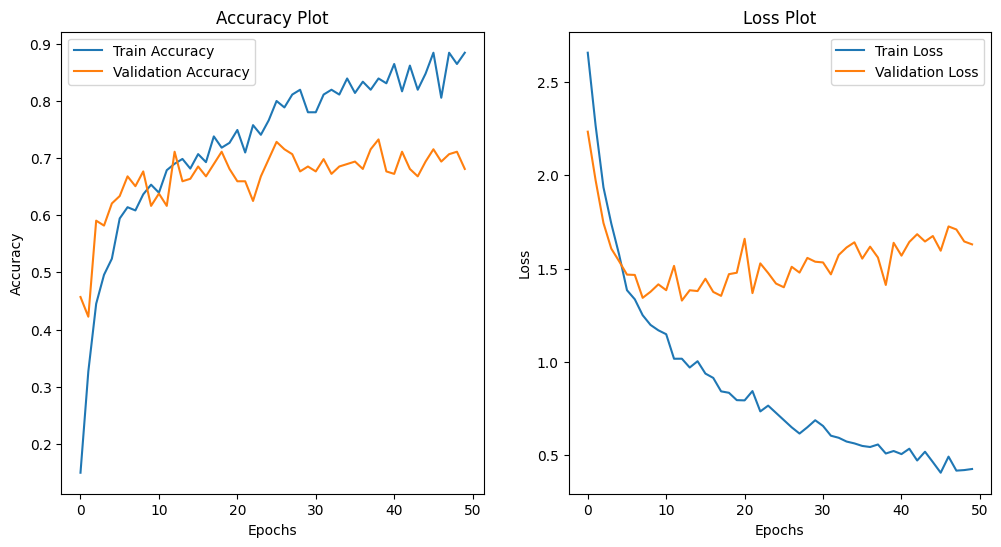

In [5]:

# Automated training, evaluation, and conversion for multiple architectures
architectures = ['vgg16', 'vgg19']

for architecture in architectures:
    print(f"Training model: {architecture}")
    
    # Train model for the given architecture
    model, history = train_model(architecture)
    
    # Save training metrics plots
    plot_metrics(history, architecture)

    # Evaluate the model
    print(f"Evaluating model: {architecture}")
    train_generator, val_generator = get_data_generators()
    evaluate_model(model, val_generator, architecture)

    # Convert model to TensorFlow Lite
    convert_to_tflite(model, architecture)


In [6]:
from tensorflow.keras.backend import clear_session
import gc

# Clear the session
clear_session()

# Run garbage collection to free memory
gc.collect()


454

In [7]:

# Convert to TensorFlow Lite
import tensorflow as tf
from tensorflow.keras.models import load_model

# def load_model(model_path):
#     """
#     Load a TensorFlow/Keras model from a given path.
#     """
#     try:
#         model = load_model('../models/violence/unet_segmentation.h5')
#         print(f"Model loaded successfully from {model_path}")
#         return model
#     except Exception as e:
#         print(f"Failed to load the model from {model_path}: {e}")
#         return None

def convert_to_tflite_with_optimization(model, architecture):
    """
    Convert a TensorFlow/Keras model to TensorFlow Lite format with optimization and save it.
    """
    model_path = f"../models/violence/{architecture}_saved_model"
    tflite_model_path = f"../models/violence/{architecture}_model_optimized.tflite"

    # Save the model in TensorFlow SavedModel format
    model.save(model_path)
    print(f"Model saved to {model_path}")

    try:
        # Convert the model to TensorFlow Lite format with optimization
        converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()
        print("Model successfully converted to TensorFlow Lite format with optimization.")

        # Save the TFLite model
        with open(tflite_model_path, "wb") as f:
            f.write(tflite_model)
        print(f"Optimized TFLite model saved to {tflite_model_path}")
    except Exception as e:
        print(f"Failed to convert the model to TensorFlow Lite format: {e}")





In [8]:
# Example usage
if __name__ == "__main__":
    # Path to the existing model file
    model_file_path = "../models/violence/unet_segmentation.h5"

    # Load the model
    loaded_model = load_model('../models/violence/unet_segmentation.h5')

    

In [9]:

if loaded_model:
    convert_to_tflite(loaded_model, 'unet_violence_Seg')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/violence/unet_violence_Seg_saved_model.

In [11]:
from tensorflow.keras.models import load_model

# Step 1: Load the .h5 model
model = load_model('../models/violence/unet_segmentation.h5')

# Step 2: Save as SavedModel format
model.export("../models/violence/unet_segmentation_saved_model")



INFO:tensorflow:Assets written to: ../models/violence/unet_segmentation_saved_model\assets


INFO:tensorflow:Assets written to: ../models/violence/unet_segmentation_saved_model\assets


Saved artifact at '../models/violence/unet_segmentation_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)
Captures:
  2245851680208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851680784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851680016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851681552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851681360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851682320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851682512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851683088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851683280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2245851683856: TensorSpec(shape=(), dtype=tf.resource, name=N

In [14]:
import tensorflow as tf
from keras.layers import TFSMLayer

model_layer = TFSMLayer("../models/violence/unet_segmentation_saved_model", call_endpoint="serving_default")
